In [ ]:
"""
1. Understand the problem. 
   We'll look at each variable and do a philosophical analysis about their meaning and importance for this problem.
2. Univariable study. 
   We'll just focus on the dependent variable ('SalePrice') and try to know a little bit more about it.
3. Multivariate study. 
   We'll try to understand how the dependent variable and independent variables relate.
4. Basic cleaning. 
   We'll clean the dataset and handle the missing data, outliers and categorical variables.
5. Test assumptions. 
   We'll check if our data meets the assumptions required by most multivariate techniques.
"""

In [390]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as st
from sklearn import linear_model
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [95]:
def read_data(file_path):
    return pd.read_csv(file_path, keep_default_na=False)

In [96]:
def univariate_analysis(df):
    """Univariate Analysis of target variable"""
    
    print df['SalePrice'].describe()
    sns.distplot(df['SalePrice'])

    # Positive skewed
    print df['SalePrice'].skew()

    # Positive kurtosis; more prone to outliers -> "light-tailed"
    print df['SalePrice'].kurt()

In [97]:
def multivariate_analysis(df):
    """Multivariate Analysis"""
    # Correlation matrix
    corrmat = df.corr()
    f, ax = plt.subplots(figsize=(12, 9))
    sns.heatmap(corrmat, vmax=.8, square=True)
    plt.show()

    # SalePrice correlation matrix (zoomed)
    k = 10 #number of variables for heatmap
    cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
    cm = np.corrcoef(df[cols].values.T)
    sns.set(font_scale=1.25)
    hm = sns.heatmap(
        cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
        yticklabels=cols.values, xticklabels=cols.values
    )
    plt.show()

    # 'OverallQual', 'GrLivArea' and 'TotalBsmtSF' are strongly correlated with 'SalePrice'
    # 'GarageCars' and 'GarageArea' are also some of the most strongly correlated variables

In [98]:
def missing_data(df):
    """Missing data"""
    # In this dataset, we dont really have any missing data, we conside NA as a separate category
    perc_missing_values = train_X.isnull().sum() / train_X.shape[0]
    perc_missing_values = perc_missing_values.sort_values(ascending=False)

    # PoolQC, MiscFeature, Alley, Fence seem important variable and we wont remove them, 
    # instead, we shall convert them into boolean variables and use them in our training data

In [530]:
def data_massaging(df):    
    # remove and replace some columns and values
    df['LotFrontage'] = df['LotFrontage'].replace('NA', 0).astype('int64')
    df['MasVnrArea'] = df['MasVnrArea'].replace('NA', 0).astype('int64')
    df['TotalBsmtSF'] = df['TotalBsmtSF'].replace('NA', 0).astype('int64')
    df['BsmtUnfSF'] = df['BsmtUnfSF'].replace('NA', 0).astype('int64')
    df['GarageCars'] = df['GarageCars'].replace('NA', 0).astype('int64')
    df['BsmtFullBath'] = df['BsmtFullBath'].replace('NA', 0).astype('int64')
    df['BsmtHalfBath'] = df['BsmtHalfBath'].replace('NA', 0).astype('int64')

    # new features
    df['VintageBuilt'] = df['YearBuilt'].apply(lambda year: 1 if year < 1920 else 0)
    df['LatestBuilt'] = df['YearBuilt'].apply(lambda year: 1 if year > 2000 else 0)
    df['ageOfHouse'] = df['YrSold'] - df['YearBuilt']
    df['ageOfHouseSinceRemodeling'] = df['YrSold'] - df['YearRemodAdd']
    df['TotalFullBaths'] = df['BsmtFullBath'] + df['FullBath']
    df['TotalHalfBaths'] = df['BsmtHalfBath'] + df['HalfBath']
    df['TotalPorchArea'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

#     df = df.drop('YearRemodAdd', 1)
#     df = df.drop('YrSold', 1)
#     df = df.drop('GarageYrBlt', 1)
#     df = df.drop('MoSold', 1)

    # Only keep total bsmt area
#     df = df.drop('BsmtFinSF1', 1)
#     df = df.drop('BsmtFinSF2', 1)
#     df = df.drop('BsmtUnfSF', 1)
    
    # 1stFlrSF + 2ndFlrSF ~ GrLivArea
#     df = df.drop('GrLivArea', 1)
#     df = df.drop('OpenPorchSF', 1)
#     df = df.drop('EnclosedPorch', 1)
#     df = df.drop('3SsnPorch', 1)
#     df = df.drop('ScreenPorch', 1)

    # GarageCond and GarageQual are highly correlated
#     df = df.drop('GarageCond', 1)
#     df = df.drop('GarageArea', 1)

    df = df.drop('Id', 1)

    # transformed into categorical features.
    df['MSSubClass'] = df['MSSubClass'].apply(str)
    df['YrSold'] = df['YrSold'].astype(str)
    df['MoSold'] = df['MoSold'].astype(str)
    
    # separate out numeric, categorical and ordinal data-frames
    numeric_df = df.select_dtypes(include=['int64'])
    categorical_df = df.select_dtypes(include=['object'])

    ordinal_columns = [
        'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
        'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'KitchenQual',
        'FireplaceQu', 'GarageFinish', 'GarageQual', 'PavedDrive', 'PoolQC', 'Fence'
    ]
    ordinal_df = pd.DataFrame(categorical_df[ordinal_columns])

    non_ordinal_columns = list(set(categorical_df.columns) - set(ordinal_columns))
    non_ordinal_df = pd.DataFrame(categorical_df[non_ordinal_columns])
    
    # Replace ordinal categorical variables with numerical values
    replace_rules = {
        'ExterQual':    {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA":0},
        'ExterCond':    {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1},
        'BsmtQual':     {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0},
        'BsmtCond':     {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0},
        'BsmtExposure': {"Gd": 4, "Av": 3, "Mn": 2, "No": 1, "NA": 0},
        'BsmtFinType1': {"GLQ": 6, "ALQ": 5, "BLQ": 4, "Rec": 3, "LwQ": 2, "Unf": 1, "NA": 0},
        'BsmtFinType2': {"GLQ": 6, "ALQ": 5, "BLQ": 4, "Rec": 3, "LwQ": 2, "Unf": 1, "NA": 0},
        'HeatingQC':    {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1},
        'CentralAir':   {"Y": 1, "N": 0},
        'KitchenQual':  {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0},
        'FireplaceQu':  {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0},
        'GarageFinish': {"Fin": 3, "RFn": 2, "Unf": 1, "NA": 0},
        'GarageQual':   {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0},
        'PavedDrive':   {"Y": 2, "P": 1, "N": 0},
        'PoolQC':       {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "NA": 0},
        'Fence':        {"GdPrv": 4, "MnPrv": 3, "GdWo": 2, "MnWw": 1, "NA": 0},
    }
    ordinal_df.replace(replace_rules, inplace=True)
    
    # generate dummy variables for  non-ordinal categorical variables - ONE HOT ENCODING
    dummy_non_ordinal_df = pd.get_dummies(non_ordinal_df)
    
    # numerical values
    numeric_df = numeric_df
    
    # merge the dataframes
    refined_df = pd.concat([ordinal_df, dummy_non_ordinal_df, numeric_df], axis=1)

    assert df.shape[0] == refined_df.shape[0]
    return refined_df

In [100]:
def sort_columns(df):
    columns = sorted(df.columns)
    return df[columns]

In [101]:
def ensure_columns_are_same(train_X, test_X):
    incorrect_train_columns, incorrect_test_columns = set(), set()
    incorrect_train_columns |= (set(train_X.columns) - set(test_X.columns))
    incorrect_test_columns |= (set(test_X.columns) - set(train_X.columns))
    
    train_X = train_X.drop(list(incorrect_train_columns), axis=1)
    test_X = test_X.drop(list(incorrect_test_columns), axis=1)
    
    assert train_X.shape[1] == test_X.shape[1]
    return sort_columns(train_X), sort_columns(test_X)

In [102]:
def linear_regression(train_X, train_y, test_X):
    train_X, test_X = ensure_columns_are_same(train_X, test_X)
    lm = linear_model.LinearRegression()
    lm.fit(train_X, np.log(train_y))
    predicted_test_y = lm.predict(test_X)
    return lm, np.exp(predicted_test_y), train_X, test_X

In [103]:
def elasticnet_regression(alpha, l1_ratio, train_X, train_y, test_X):
    train_X, test_X = ensure_columns_are_same(train_X, test_X)
    lm = linear_model.ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    lm.fit(train_X, np.log(train_y))
    predicted_test_y = lm.predict(test_X)
    return lm, np.exp(predicted_test_y), train_X, test_X

In [104]:
def ridge_regression(alpha, train_X, train_y, test_X):
    train_X, test_X = ensure_columns_are_same(train_X, test_X)
    lm = linear_model.Ridge(alpha=alpha)
    lm.fit(train_X, np.log(train_y))
    predicted_test_y = lm.predict(test_X)
    return lm, np.exp(predicted_test_y), train_X, test_X

In [105]:
def lasso(alpha, train_X, train_y, test_X):
    train_X, test_X = ensure_columns_are_same(train_X, test_X)
    lm = linear_model.Lasso(alpha=alpha)
    lm.fit(train_X, np.log(train_y))
    predicted_test_y = lm.predict(test_X)
    return lm, np.exp(predicted_test_y), train_X, test_X

In [106]:
# Random Forest is a Bagging based model.

def random_forest_regressor(train_X, train_y, test_X, **kwargs):
    train_X, test_X = ensure_columns_are_same(train_X, test_X)
    lm = RandomForestRegressor(
        max_depth=kwargs['max_depth'],
        max_features=kwargs['max_features'],
        min_samples_split=kwargs['min_samples_split'],
        n_estimators=kwargs['n_estimators'],
        min_samples_leaf=kwargs['min_samples_leaf'],
    )
    lm.fit(train_X, np.log(train_y))
    predicted_test_y = lm.predict(test_X)
    return lm, np.exp(predicted_test_y), train_X, test_X

In [456]:
def gbm_regressor(train_X, train_y, test_X, **kwargs):
    train_X, test_X = ensure_columns_are_same(train_X, test_X)
    lm = GradientBoostingRegressor(
        max_depth=kwargs['max_depth'],
        max_features=kwargs['max_features'],
        min_samples_split=kwargs['min_samples_split'],
        n_estimators=kwargs['n_estimators'],
        min_samples_leaf=kwargs['min_samples_leaf'],
        loss=kwargs['loss'],
        learning_rate=kwargs['learning_rate']
    )
    lm.fit(train_X, np.log(train_y))
    predicted_test_y = lm.predict(test_X)
    return lm, np.exp(predicted_test_y), train_X, test_X

In [107]:
def xgb_regressor(train_X, train_y, test_X, **kwargs):
    train_X, test_X = ensure_columns_are_same(train_X, test_X)
    try:
        lm = XGBRegressor(
            reg_alpha=kwargs['reg_alpha'],
            colsample_bytree=kwargs['colsample_bytree'],
            learning_rate=kwargs['learning_rate'],
            min_child_weight=kwargs['min_child_weight'],
            n_estimators=kwargs['n_estimators'],
            subsample=kwargs['subsample'],
            max_depth=kwargs['max_depth'],
            gamma=kwargs['gamma']
        )
    except:
        lm = XGBRegressor()
    lm.fit(train_X, np.log(train_y))
    predicted_test_y = lm.predict(test_X)
    return lm, np.exp(predicted_test_y), train_X, test_X

In [108]:
def RMSE(target, prediction):
    return np.sqrt(((prediction - target) ** 2).mean())

In [109]:
def grid_search_report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [110]:
def prepare_for_upload(predicted_test_y):
    n = len(predicted_test_y)
    predictions = pd.DataFrame()
    predictions['Id'] = np.array([n + i + 1 for i in range(1, n + 1)])
    predictions['SalePrice'] = predicted_test_y
    predictions.to_csv('HousePrice_submission.csv', index=False)

In [531]:
training_data_file = 'train.csv'
test_data_file = 'test.csv'

train_X = read_data(training_data_file)
test_X = read_data(test_data_file)

refined_train_X = data_massaging(train_X)
refined_test_X = data_massaging(test_X)

refined_train_y = pd.DataFrame(refined_train_X['SalePrice'])
refined_train_X = refined_train_X.drop('SalePrice', axis=1)

,ExterQual,ExterCond
ExterQual,1.000000,0.009184
ExterCond,0.009184,1.000000


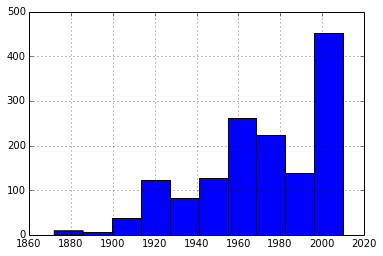

In [400]:
pd.set_option('display.max_columns', None)
train_X['YearBuilt'].hist()

refined_train_X[['ExterQual', 'ExterCond']].corr()

In [532]:
# split the training data into train and validation sets into 2/3 and 1/3
ref_train_X, ref_val_X, ref_train_y, ref_val_y = train_test_split(
    refined_train_X,
    refined_train_y,
    test_size=0.33,
    random_state=42,
)

In [22]:
# train for validation set

In [533]:
model, predicted_val_y, _, _ = linear_regression(
    ref_train_X,
    ref_train_y,
    ref_val_X,
)
print "Mean squared error: %.2f" % RMSE(ref_val_y, predicted_val_y)
print "Variance score: %.2f" % r2_score(ref_val_y, predicted_val_y)

Mean squared error: 28150.20
Variance score: 0.89


In [534]:
for alpha in [0.0001, 0.0005, 0.001, 0.005]:
    for l1_ratio in [0.25, 0.5]:
        model, predicted_val_y, _, _ = elasticnet_regression(
            alpha,
            l1_ratio,
            ref_train_X,
            ref_train_y,
            ref_val_X,
        )
        print alpha, l1_ratio
        print "Mean squared error: %.2f" % np.sqrt(mean_squared_error(ref_val_y, predicted_val_y))
        print "Variance score: %.2f" % r2_score(ref_val_y, predicted_val_y)

0.0001 0.25
Mean squared error: 27372.88
Variance score: 0.90
0.0001 0.5
Mean squared error: 25691.87
Variance score: 0.91
0.0005 0.25
Mean squared error: 28836.57
Variance score: 0.89
0.0005 0.5
Mean squared error: 27302.48
Variance score: 0.90
0.001 0.25
Mean squared error: 29431.04
Variance score: 0.88
0.001 0.5
Mean squared error: 28559.08
Variance score: 0.89
0.005 0.25
Mean squared error: 30279.78
Variance score: 0.88
0.005 0.5
Mean squared error: 31118.63
Variance score: 0.87


In [535]:
for alpha in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]:
    model, predicted_val_y, _, _ = ridge_regression(
        alpha,
        ref_train_X,
        ref_train_y,
        ref_val_X,
    )
    print alpha
    print "Mean squared error: %.2f" % RMSE(ref_val_y, predicted_val_y)
    print "Variance score: %.2f" % r2_score(ref_val_y, predicted_val_y)

0.001
Mean squared error: 28159.23
Variance score: 0.89
0.005
Mean squared error: 28197.41
Variance score: 0.89
0.01
Mean squared error: 28248.99
Variance score: 0.89
0.05
Mean squared error: 28721.86
Variance score: 0.89
0.1
Mean squared error: 29282.29
Variance score: 0.88
0.5
Mean squared error: 31204.51
Variance score: 0.87
1
Mean squared error: 31649.75
Variance score: 0.86


In [536]:
for alpha in [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]:
    model, predicted_val_y, _, _ = lasso(
        alpha,
        ref_train_X,
        ref_train_y,
        ref_val_X,
    )
    print alpha
    print "Mean squared error: %.2f" % np.sqrt(mean_squared_error(ref_val_y, predicted_val_y))
    print "Variance score: %.2f" % r2_score(ref_val_y, predicted_val_y)


0.0001
Mean squared error: 23656.73
Variance score: 0.92
0.0005
Mean squared error: 24883.79
Variance score: 0.92
0.001
Mean squared error: 28682.06
Variance score: 0.89
0.005
Mean squared error: 31833.74
Variance score: 0.86
0.01
Mean squared error: 33056.14
Variance score: 0.85
0.05
Mean squared error: 35477.89
Variance score: 0.83
0.1
Mean squared error: 37142.15
Variance score: 0.81
0.5
Mean squared error: 35838.29
Variance score: 0.83
1
Mean squared error: 35484.55
Variance score: 0.83


In [537]:
random_forest_parameters = {
    'max_features': 0.5,
    'min_samples_split': 2,
    'n_estimators': 20,
    'max_depth': 10,
    'min_samples_leaf': 1
}
model, predicted_val_y, _, _ = random_forest_regressor(
    ref_train_X,
    ref_train_y,
    ref_val_X,
    **random_forest_parameters
)
print "Mean squared error: %.2f" % np.sqrt(mean_squared_error(ref_val_y, predicted_val_y))
print "Variance score: %.2f" % r2_score(ref_val_y, predicted_val_y)

Mean squared error: 34225.98
Variance score: 0.84


/Library/Python/2.7/site-packages/ipykernel/__main__.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [558]:
gbm_parameters = {
    'max_features': 'sqrt',
    'min_samples_split': 2,
    'n_estimators': 4000,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'loss': 'ls',
    'learning_rate': 0.01
}
model, predicted_val_y, _, _ = gbm_regressor(
    ref_train_X,
    ref_train_y,
    ref_val_X,
    **gbm_parameters
)
print "Mean squared error: %.2f" % np.sqrt(mean_squared_error(ref_val_y, predicted_val_y))
print "Variance score: %.2f" % r2_score(ref_val_y, predicted_val_y)

Mean squared error: 29987.02
Variance score: 0.88


In [539]:
xgb_parameters = dict(
     colsample_bytree=0.2,
     gamma=0.0,
     learning_rate=0.01,
     max_depth=4,
     min_child_weight=1.5,
     n_estimators=7200,                                                                  
     reg_alpha=0.9,
     reg_lambda=0.6,
     subsample=0.2,
     seed=42,
     silent=1
)

model, predicted_val_y, _, _ = xgb_regressor(
    ref_train_X,
    ref_train_y,
    ref_val_X,
    **xgb_parameters
)
print "Mean squared error: %.2f" % np.sqrt(mean_squared_error(ref_val_y, predicted_val_y))
print "Variance score: %.2f" % r2_score(ref_val_y, predicted_val_y)

Mean squared error: 31614.79
Variance score: 0.86


In [ ]:
one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)
xgb_param_grid = {
    "n_estimators": st.randint(3, 40),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.05, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}

xgbreg = XGBRegressor(nthreads=-1)

gs = RandomizedSearchCV(xgbreg, xgb_param_grid, n_jobs=1)  
gs.fit(refined_train_X, refined_train_y)  
grid_search_report(gs.cv_results_)

In [ ]:
# random forest grid search; use a full grid over all parameters
rf_param_grid = {
    "max_depth": [3, 5, 7, 10],
    "max_features": [1, 3, 10],
    "min_samples_split": [2, 3, 10],
    "min_samples_leaf": [1, 3, 10],
    "n_estimators": [20, 50, 70,],
}

lm = RandomForestRegressor()

# run grid search
grid_search = GridSearchCV(lm, param_grid=rf_param_grid)
grid_search.fit(refined_train_X, refined_train_y)
grid_search_report(grid_search.cv_results_)

In [50]:
# train for the test data

In [179]:
model, predicted_test_y, refined_train_X, refined_test_X = linear_regression(
    refined_train_X,
    refined_train_y,
    refined_test_X,
)

In [196]:
alpha = 0.0001
l1_ratio = 0.5
model, predicted_test_y, refined_train_X, refined_test_X = elasticnet_regression(
    alpha,
    l1_ratio,
    refined_train_X,
    refined_train_y,
    refined_test_X,
)

In [181]:
alpha = 0.005
model, predicted_test_y, refined_train_X, refined_test_X = ridge_regression(
    alpha,
    refined_train_X,
    refined_train_y,
    refined_test_X,
)

In [509]:
alpha = 0.0001
model, predicted_test_y, refined_train_X, refined_test_X = lasso(
    alpha,
    refined_train_X,
    refined_train_y,
    refined_test_X,
)

In [438]:
random_forest_parameters = {
    'max_features': 0.5,
    'min_samples_split': 2,
    'n_estimators': 20,
    'max_depth': 10,
    'min_samples_leaf': 1
}
model, predicted_test_y, refined_train_X, refined_test_X = random_forest_regressor(
    refined_train_X,
    refined_train_y,
    refined_test_X,
    **random_forest_parameters
)

/Library/Python/2.7/site-packages/ipykernel/__main__.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [561]:
gbm_parameters = {
    'max_features': 'sqrt',
    'min_samples_split': 2,
    'n_estimators': 4000,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'loss': 'ls',
    'learning_rate': 0.01
}
model, predicted_test_y, refined_train_X, refined_test_X = gbm_regressor(
    refined_train_X,
    refined_train_y,
    refined_test_X,
    **gbm_parameters
)

In [562]:
xgb_parameters = dict(
     colsample_bytree=0.2,
     gamma=0.0,
     learning_rate=0.01,
     max_depth=4,
     min_child_weight=1.5,
     n_estimators=7200,                                                                  
     reg_alpha=0.9,
     reg_lambda=0.6,
     subsample=0.2,
     seed=42,
     silent=1
)
model, predicted_test_y, refined_train_X, refined_test_X = xgb_regressor(
    refined_train_X,
    refined_train_y,
    refined_test_X,
    **xgb_parameters
)

In [32]:
# final model to upload

In [564]:
prepare_for_upload(predicted_test_y)

In [511]:
predicted_test_y.shape

(1459,)

In [ ]:
# Try correlation analysis between some seemingly similar features